In [26]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

# Heart Disease

***Introduction***

There are multiple attributes that can contribute to a heart failure.
In order for us to prevent heart failures from earlier on, it is important to be aware of the symptoms and attributes that have the highest correlation to heart failures. 
In this project, our objective is to determine at what age range heart failures most commonly occur and which attributes have the highest possibility to result with a heart failure.
This data base goes over 76 observed attributes that are predicted to cause heart failures. 
In our project, we will be referring to the 3 attributes being serum cholesterol, types of chest pain and resting blood pressure. 


Predictors: serum cholesterol, types of chest pain, resting blood pressure, fasting blood sugar, condition.
 
***Preliminary Exploratory Data Analysis***

Reading the file into R from the web:

(Dataset and information from https://www.kaggle.com/cherngs/heart-disease-cleveland-uci and https://archive.ics.uci.edu/ml/datasets/Heart+Disease)

> age = age in years
>
> sex = 0: female; 1: male
>
> cp = type of chest pain;
>
> - 0: typical angina
>    
> - 1: atypical angina
>    
> - 2: non-anginal pain
>    
> - 3: asymptomatic
>
> trestbps = resting blood pressure
>
> chol = serum cholesterol in mg/dL
>
> fbs = fasting blood sugar > 120 mg/dL (0: false; 1: true)
>
> condition = disease condition
>
> - 0: no disease
>
> - 1: disease

In [27]:
heart_data <- read_csv("heart_cleveland_upload.csv")

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  condition = col_double()
)



Tidying for human legibility (note: LVH = left ventricular hypertrophy):

In [28]:
heart_data <- heart_data %>%
    mutate(sex = as.factor(sex),
           sex = recode(sex, "0" = "female", "1" = "male"),
          cp = as.factor(cp),
           cp = recode(cp, "0" = "typical angina",
                      "1" = "atypical angina",
                      "2" = "non-anginal pain",
                      "3" = "asymptomatic"),
           fbs = as.logical(fbs),
          restecg = as.factor(restecg),
           restecg = recode(restecg, "0" = "normal",
                           "1" = "ST-T abnormal",
                           "2" = "LVH likely"),  #left ventricular hypertrophy
           exang = as.factor(exang),
           exang = recode(exang, "0" = "no",
                          "1" = "yes"),
          slope = as.factor(slope),
           slope = recode(slope, "0" = "upsloping",
                         "1" = "flat",
                         "2" = "downsloping"),
           ca = as.factor(ca),
          thal = as.factor(thal),
           thal = recode(thal, "0" = "normal",
                        "1" = "fixed defect",
                        "2" = "reversable defect"),
          condition = as.factor(condition),
          condition = recode(condition, "0" = "no disease",
                            "1" = "disease"))
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<lgl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
69,male,typical angina,160,234,TRUE,LVH likely,131,no,0.1,flat,1,normal,no disease
69,female,typical angina,140,239,FALSE,normal,151,no,1.8,upsloping,2,normal,no disease
66,female,typical angina,150,226,FALSE,normal,114,no,2.6,downsloping,0,normal,no disease
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,male,asymptomatic,120,198,FALSE,normal,130,yes,1.6,flat,0,reversable defect,disease
35,female,asymptomatic,138,183,FALSE,normal,182,no,1.4,upsloping,0,normal,no disease
35,male,asymptomatic,126,282,FALSE,LVH likely,156,yes,0.0,upsloping,0,reversable defect,disease


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition,age_group
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<lgl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<chr>
69,male,typical angina,160,234,TRUE,LVH likely,131,no,0.1,flat,1,normal,no disease,old
69,female,typical angina,140,239,FALSE,normal,151,no,1.8,upsloping,2,normal,no disease,old
66,female,typical angina,150,226,FALSE,normal,114,no,2.6,downsloping,0,normal,no disease,old
65,male,typical angina,138,282,TRUE,LVH likely,174,no,1.4,flat,1,normal,disease,old
64,male,typical angina,110,211,FALSE,LVH likely,144,yes,1.8,flat,0,normal,no disease,old
64,male,typical angina,170,227,FALSE,LVH likely,155,no,0.6,flat,0,reversable defect,no disease,old


[1] 91

[1] 121

[1] 85

`summarise()` regrouping output by 'cp' (override with `.groups` argument)



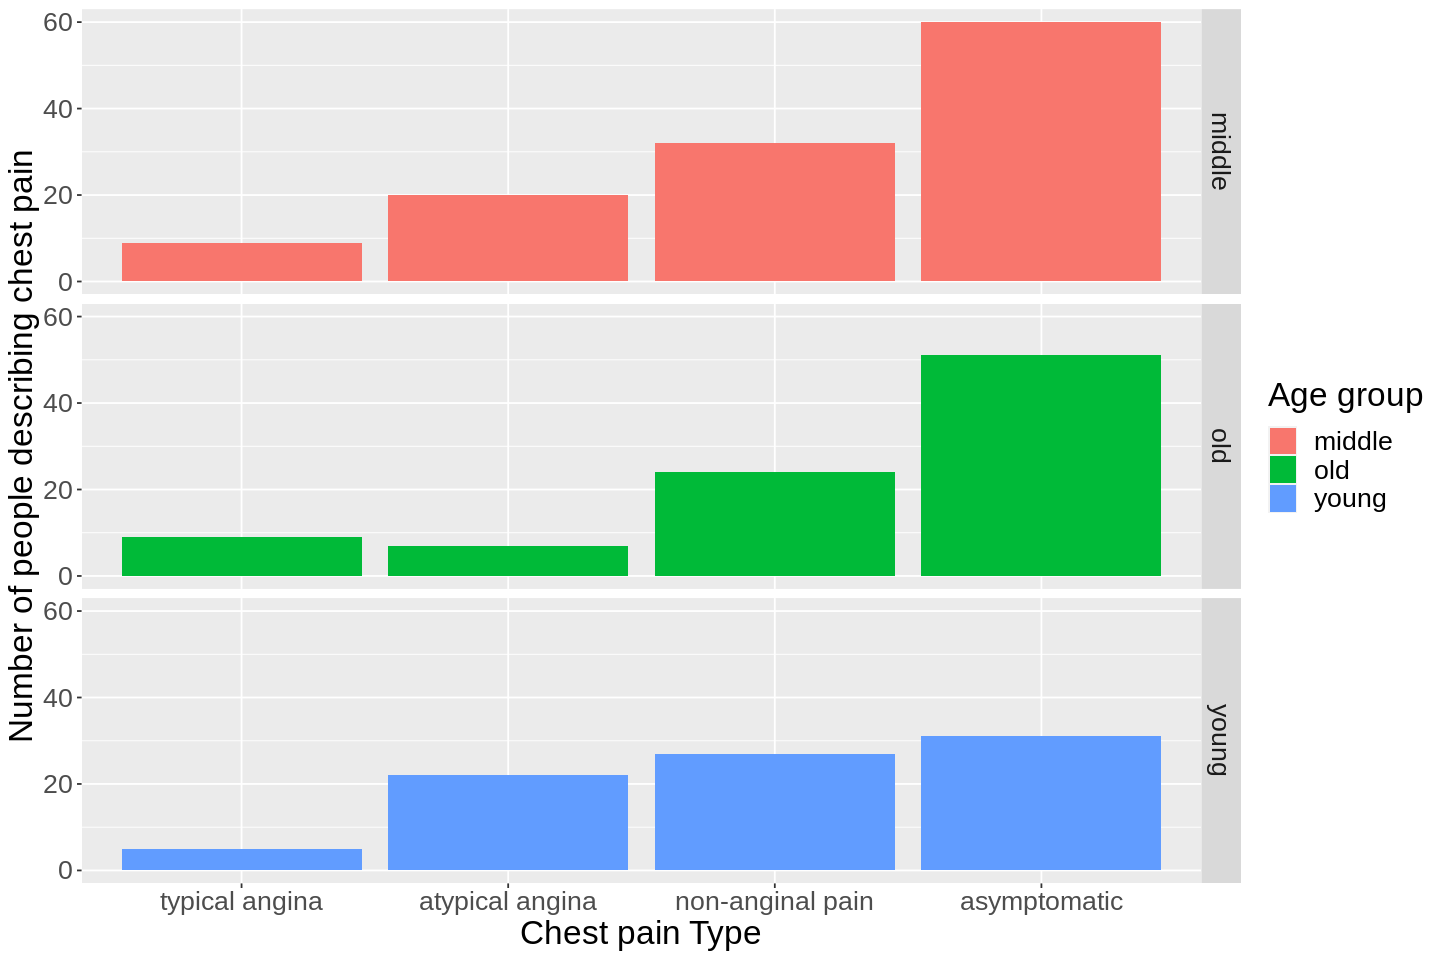

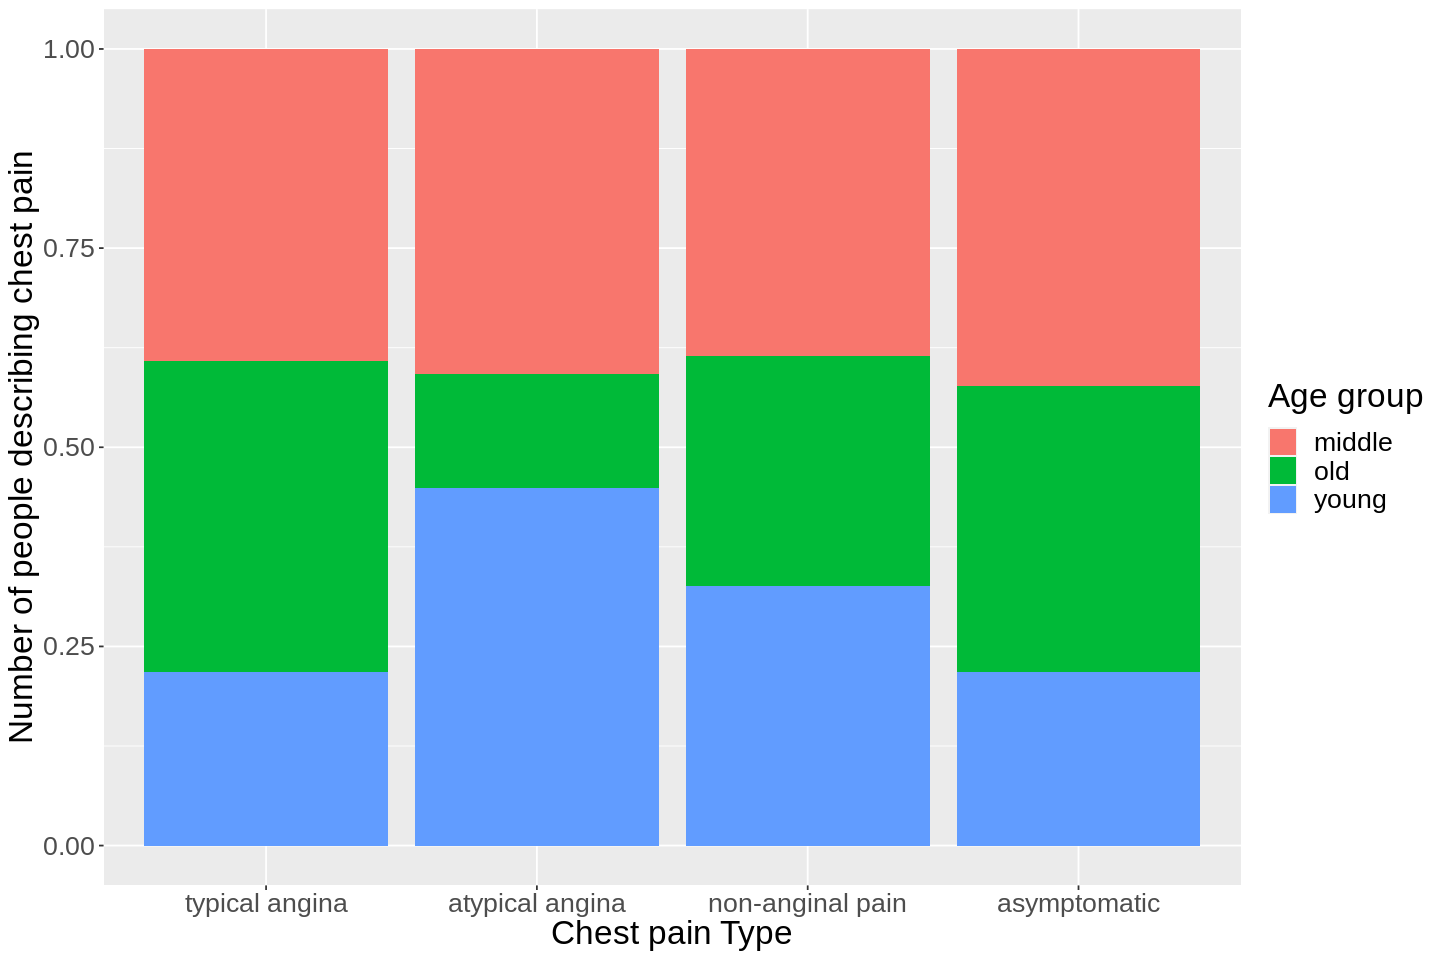

In [29]:
# 1.Divide the dataset into different age group.
heart_data <- within(heart_data,{
  age_group <- NA
  age_group[age>=60]="old"
  age_group[age>= 50 & age < 60] = "middle"
  age_group[age < 50] = "young"
})
head(heart_data)

# 2.Count the number in each group
num_old <- heart_data %>%
    filter(age_group == "old") %>%
    nrow()
num_old

num_middle <- heart_data %>%
    filter(age_group == "middle") %>%
    nrow()
num_middle

num_young <- heart_data %>%
    filter(age_group == "young") %>%
    nrow()
num_young

# Note: we can see that the majority of patients with 
# heart failure are between the ages of 50 and 60.

# 3.Find the differnt types of chest pain in each age group
chest_pains_age <- heart_data %>%
    select(cp, age_group) %>%
    group_by(cp, age_group) %>%
    summarize(count = n())

chest_pain_plot1 <- chest_pains_age %>%
    ggplot(aes(x = cp, y = count, fill = age_group)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(age_group ~.) +
    labs(x = "Chest pain Type", y = "Number of people describing chest pain",
        fill = "Age group") +
    theme(text = element_text(size = 20))
chest_pain_plot1

chest_pain_plot2 <- chest_pains_age %>%
    ggplot(aes(x = cp, y = count, fill = age_group)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(x = "Chest pain Type", y = "Number of people describing chest pain",
        fill = "Age group") +
    theme(text = element_text(size = 20))
chest_pain_plot2
# 4.Use above plot1,2 to get a conclusion.

A summary of some predictors:

In [30]:
heart_split <- initial_split(heart_data, prop = 0.75, strata = condition)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

sex_dist <- heart_train %>%
    select(sex) %>%
    group_by(sex) %>%
    summarize(count = n())
sex_dist

chest_pains <- heart_train %>%
    select(cp) %>%
    group_by(cp) %>%
    summarize(count = n())
chest_pains

cp_compare <- heart_train %>%
    select(cp, sex) %>%
    group_by(cp, sex) %>%
    summarize(reports_by_group = n()) %>%
    pivot_wider(names_from = cp, values_from = reports_by_group)
cp_compare




`summarise()` ungrouping output (override with `.groups` argument)



sex,count
<fct>,<int>
female,71
male,152


`summarise()` ungrouping output (override with `.groups` argument)



cp,count
<fct>,<int>
typical angina,18
atypical angina,33
non-anginal pain,65
asymptomatic,107


`summarise()` regrouping output by 'cp' (override with `.groups` argument)



sex,typical angina,atypical angina,non-anginal pain,asymptomatic
<fct>,<int>,<int>,<int>,<int>
female,2,12,24,33
male,16,21,41,74


Example visualization:

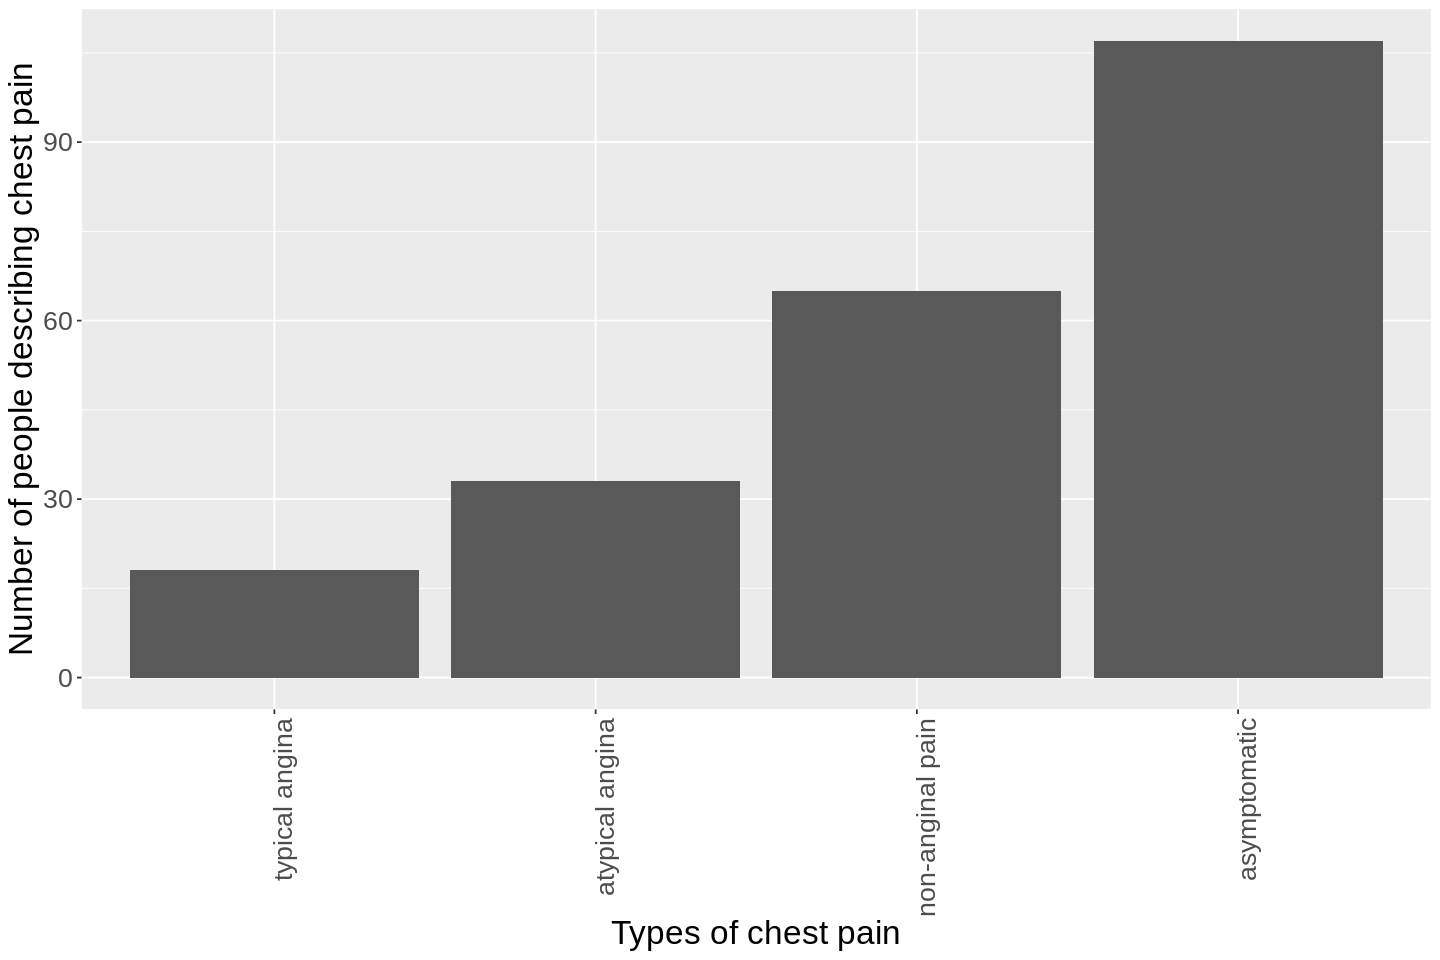

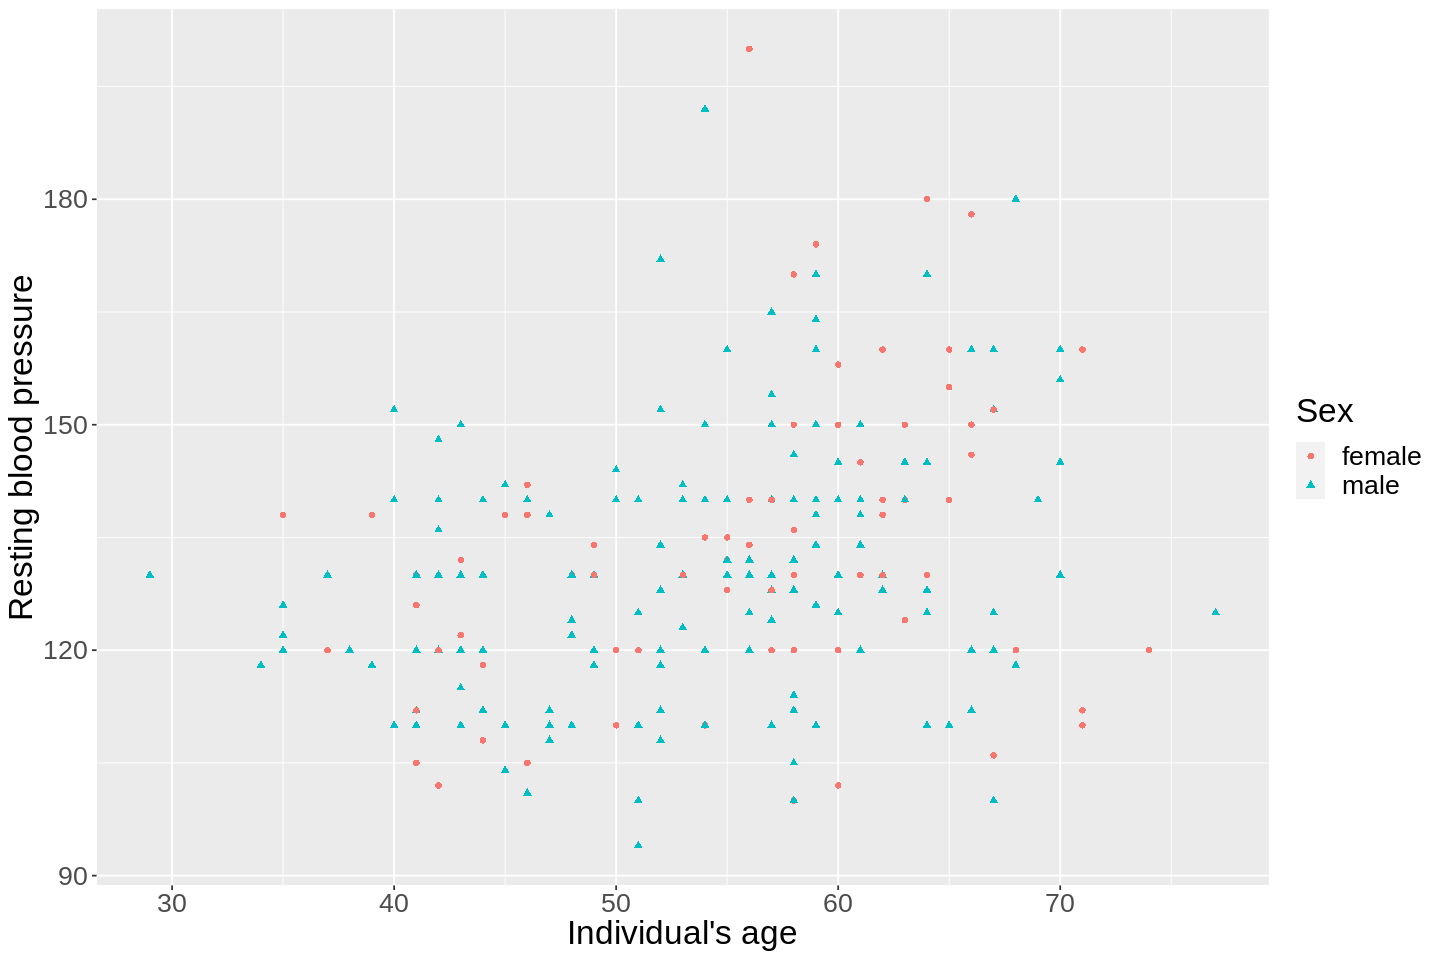

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



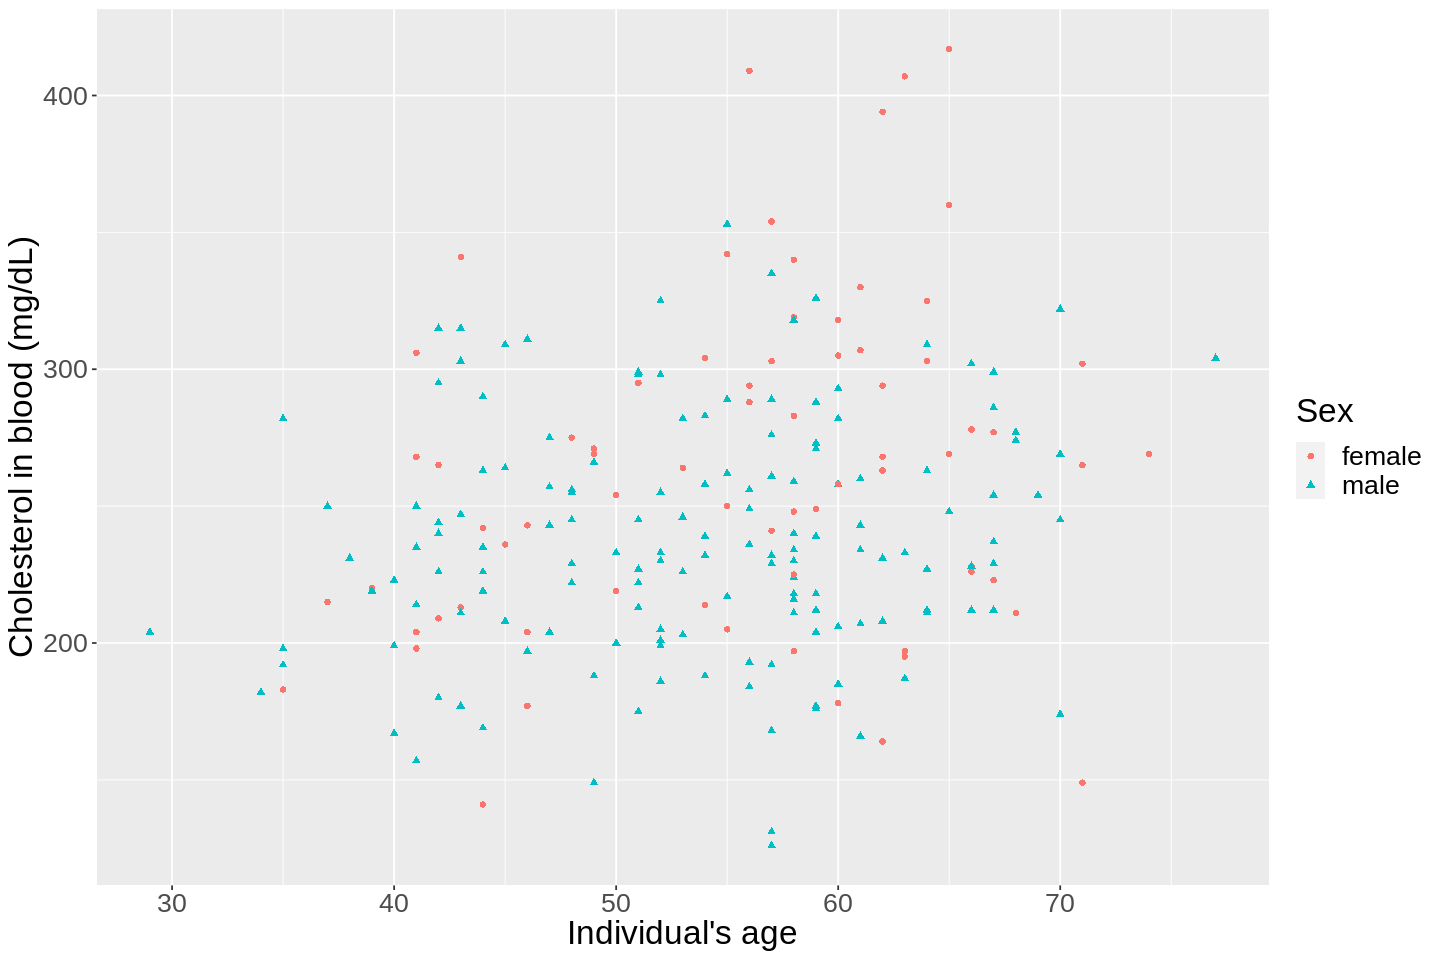

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



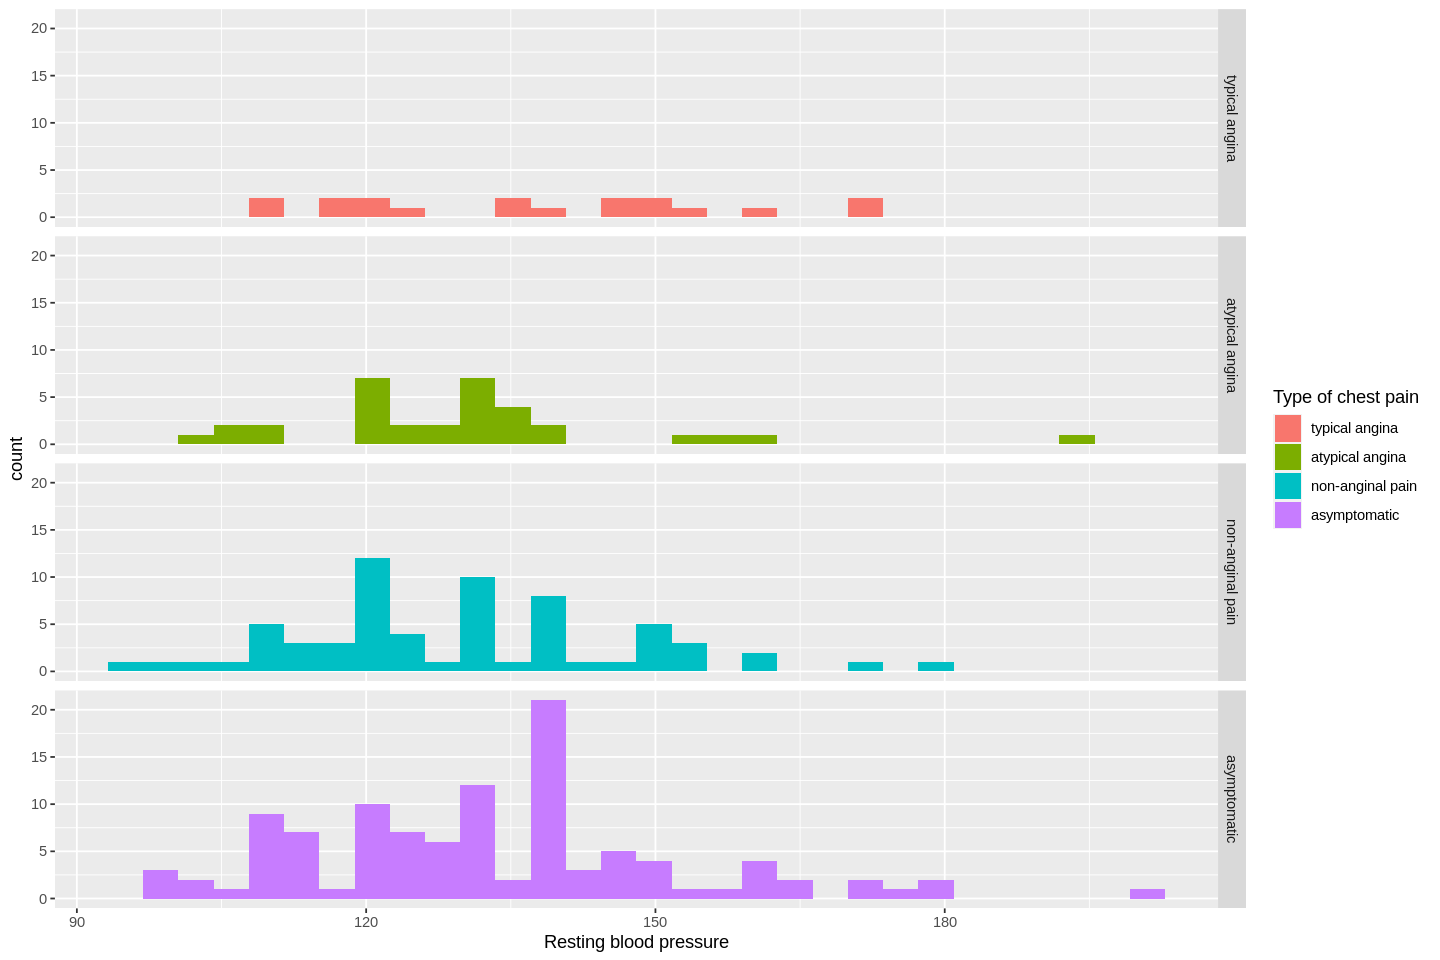

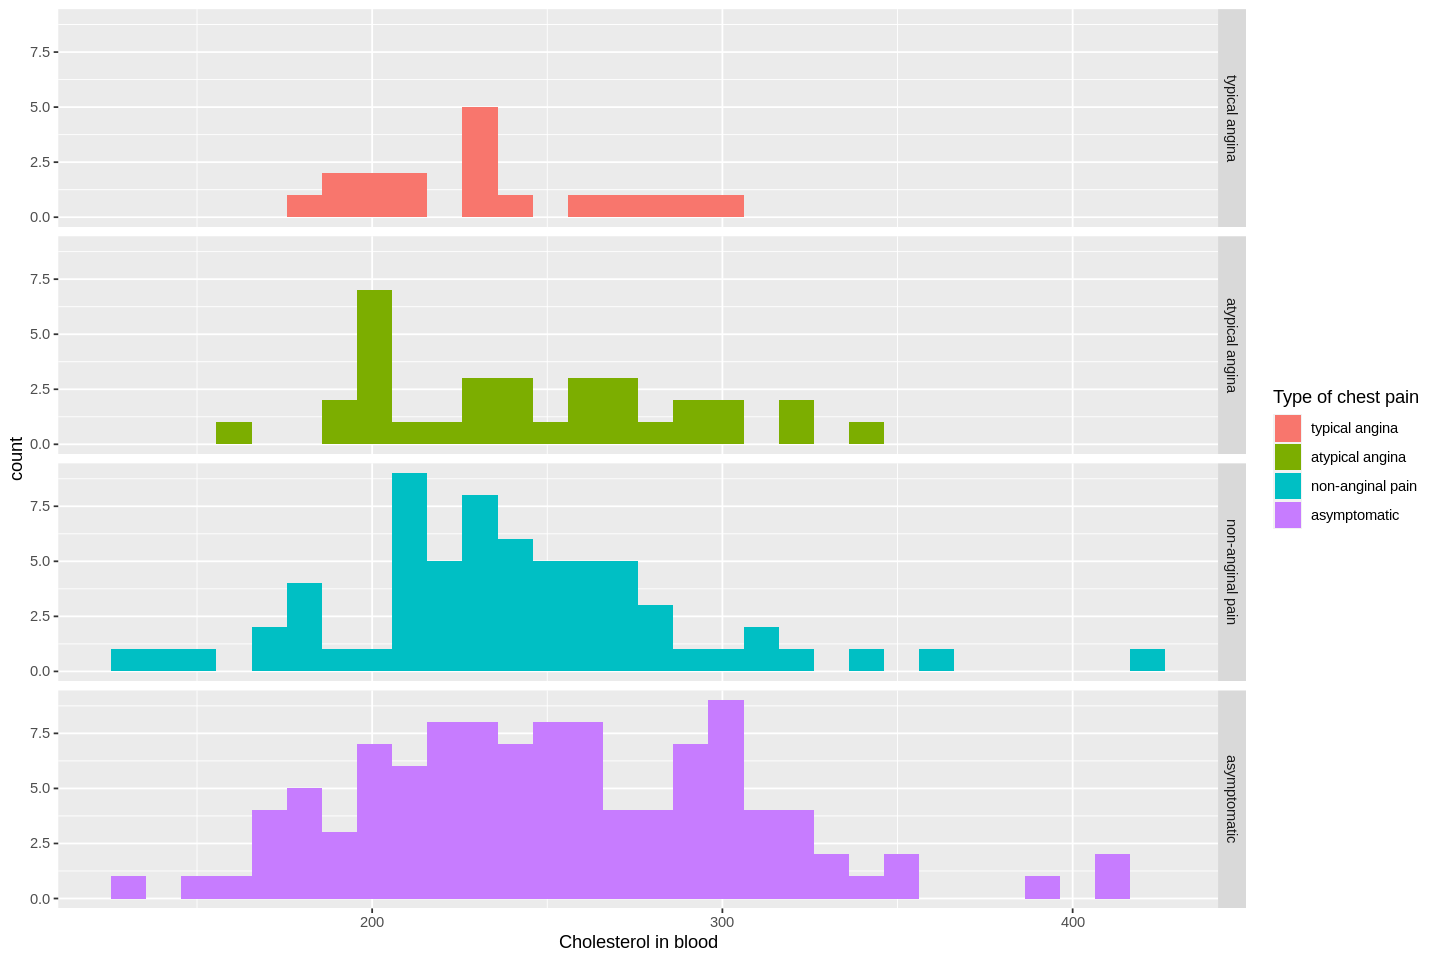

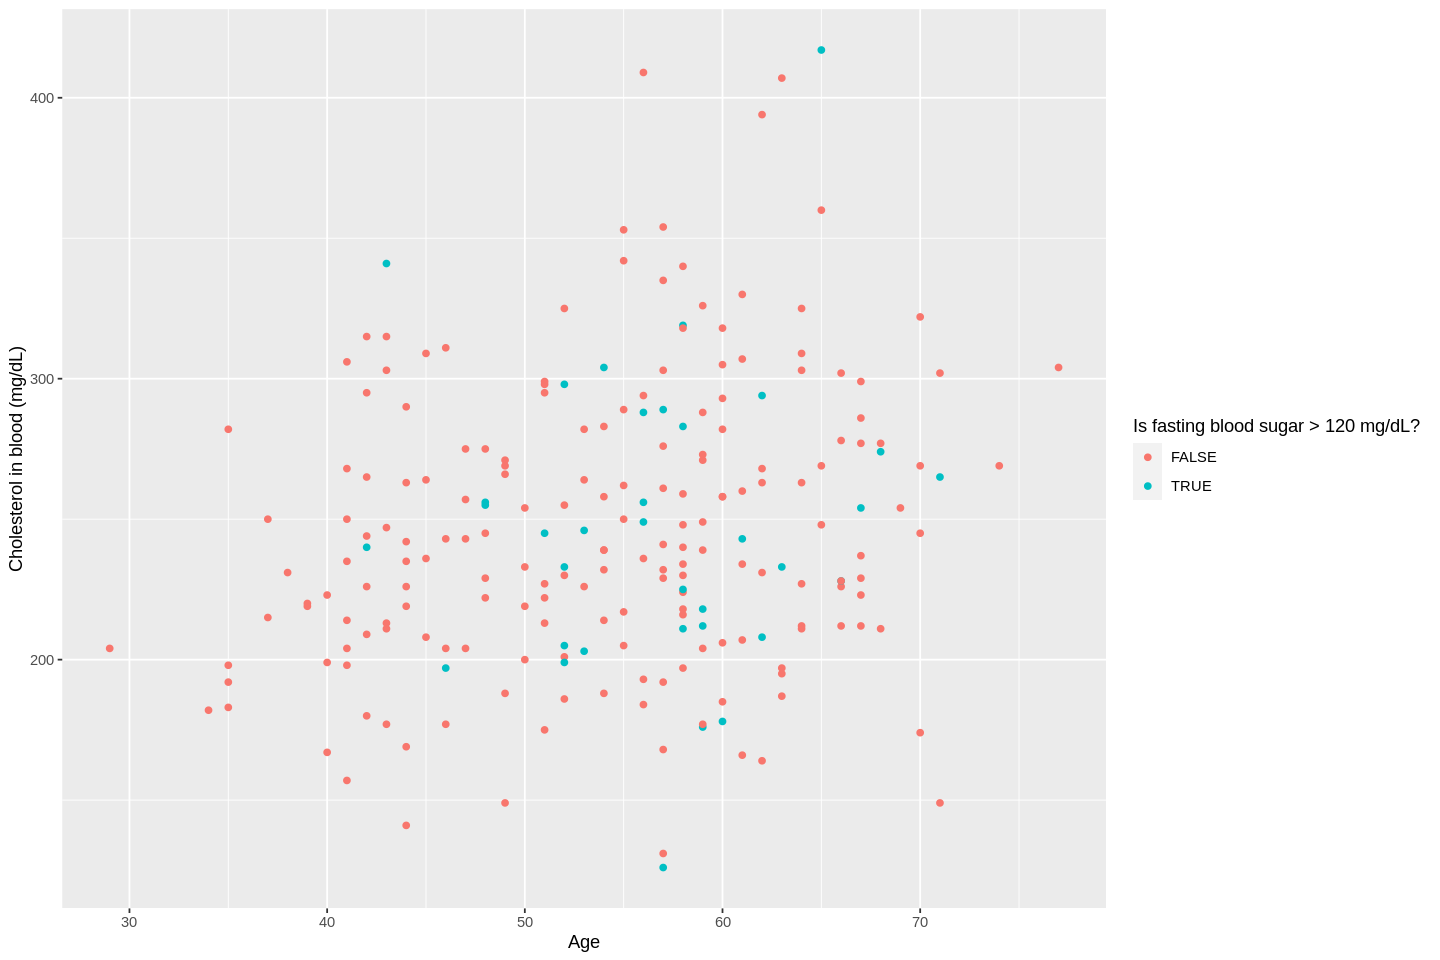

In [31]:
options(repr.plot.width = 12, repr.plot.height = 8)

chest_pain_plot <- chest_pains %>%
    ggplot(aes(x = cp, y = count)) +
    geom_bar(stat = "identity") +
    labs(x = "Types of chest pain",
         y = "Number of people describing chest pain") +
    theme(text = element_text(size = 20),
         axis.text.x = element_text(angle = 90, hjust = 1))
chest_pain_plot

age_bps_plot <- heart_train %>%
    ggplot(aes(x = age, y = trestbps, shape = sex, color = sex)) +
    geom_point() +
    labs(x = "Individual's age", y = "Resting blood pressure",
        shape = "Sex", color = "Sex") +
    theme(text = element_text(size = 20))
age_bps_plot

age_chol_plot <- heart_train %>%
    ggplot(aes(x = age, y = chol, shape = sex, color = sex)) +
    geom_point() +
    labs(x = "Individual's age", y = "Cholesterol in blood (mg/dL)",
        shape = "Sex", color = "Sex") +
    theme(text = element_text(size = 20))
age_chol_plot

cp_bps_plot <- heart_train %>%
    ggplot(aes(x = trestbps, fill = as_factor(cp))) +
    facet_grid(rows = vars(cp)) +
    geom_histogram(position = "identity") +
    labs(x = "Resting blood pressure", fill = "Type of chest pain")
cp_bps_plot

cp_chol_plot <- heart_train %>%
    ggplot(aes(x = chol, fill = as_factor(cp))) +
    facet_grid(rows = vars(cp)) +
    geom_histogram(position = "identity") +
    labs(x = "Cholesterol in blood", fill = "Type of chest pain")
cp_chol_plot

fbs_chol_plot <- heart_train %>%
    ggplot(aes(x = age, y = chol, color = fbs)) +
    geom_point() +
    labs(x = "Age", y = "Cholesterol in blood (mg/dL)", color = "Is fasting blood sugar > 120 mg/dL?")
fbs_chol_plot

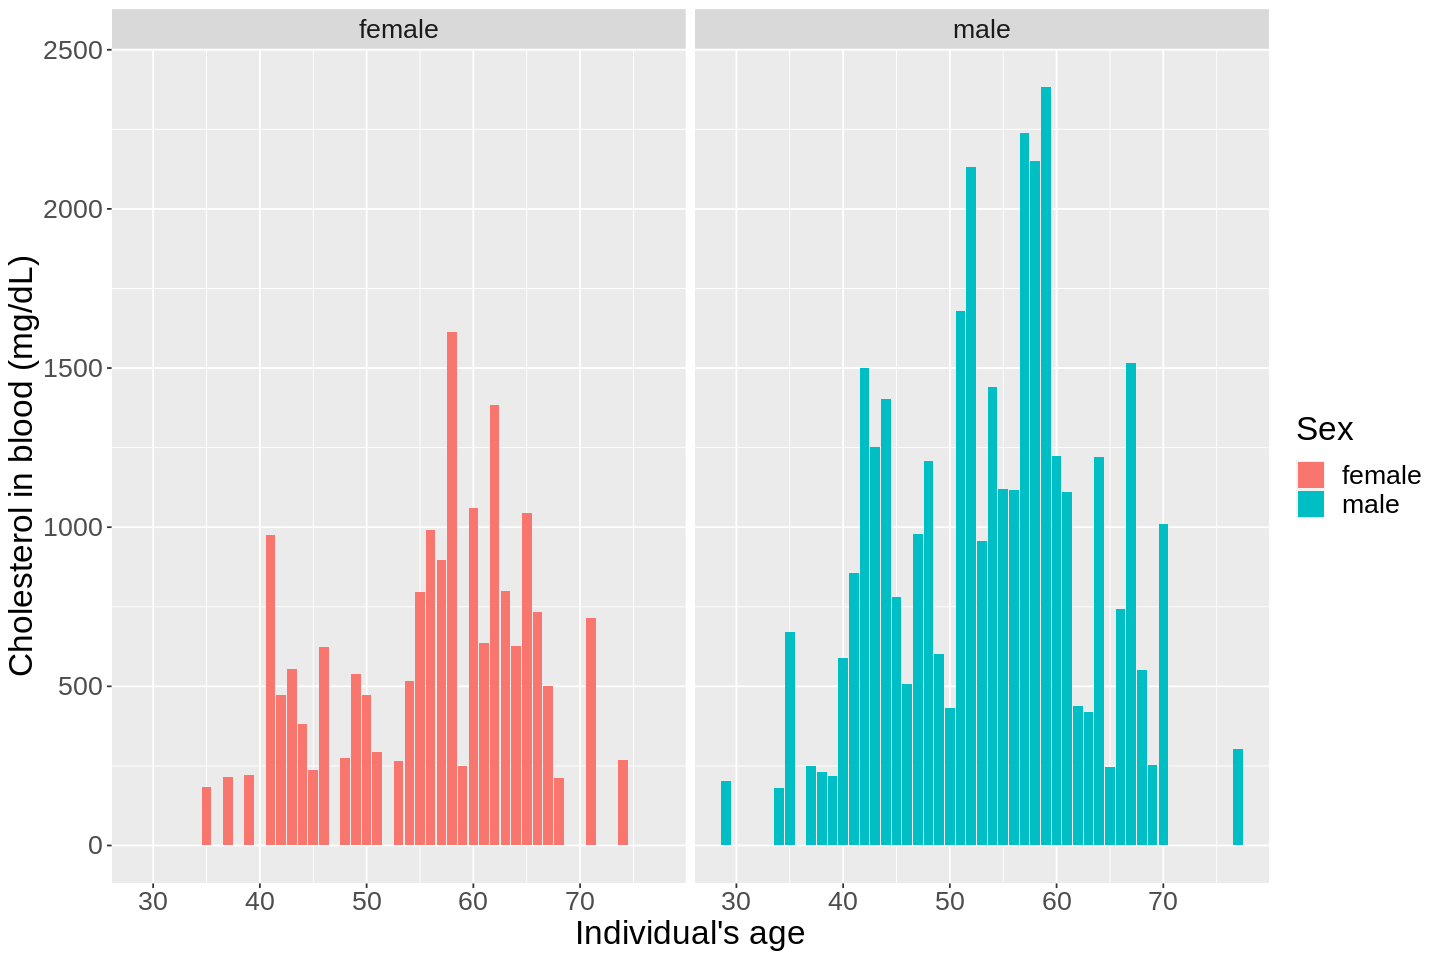

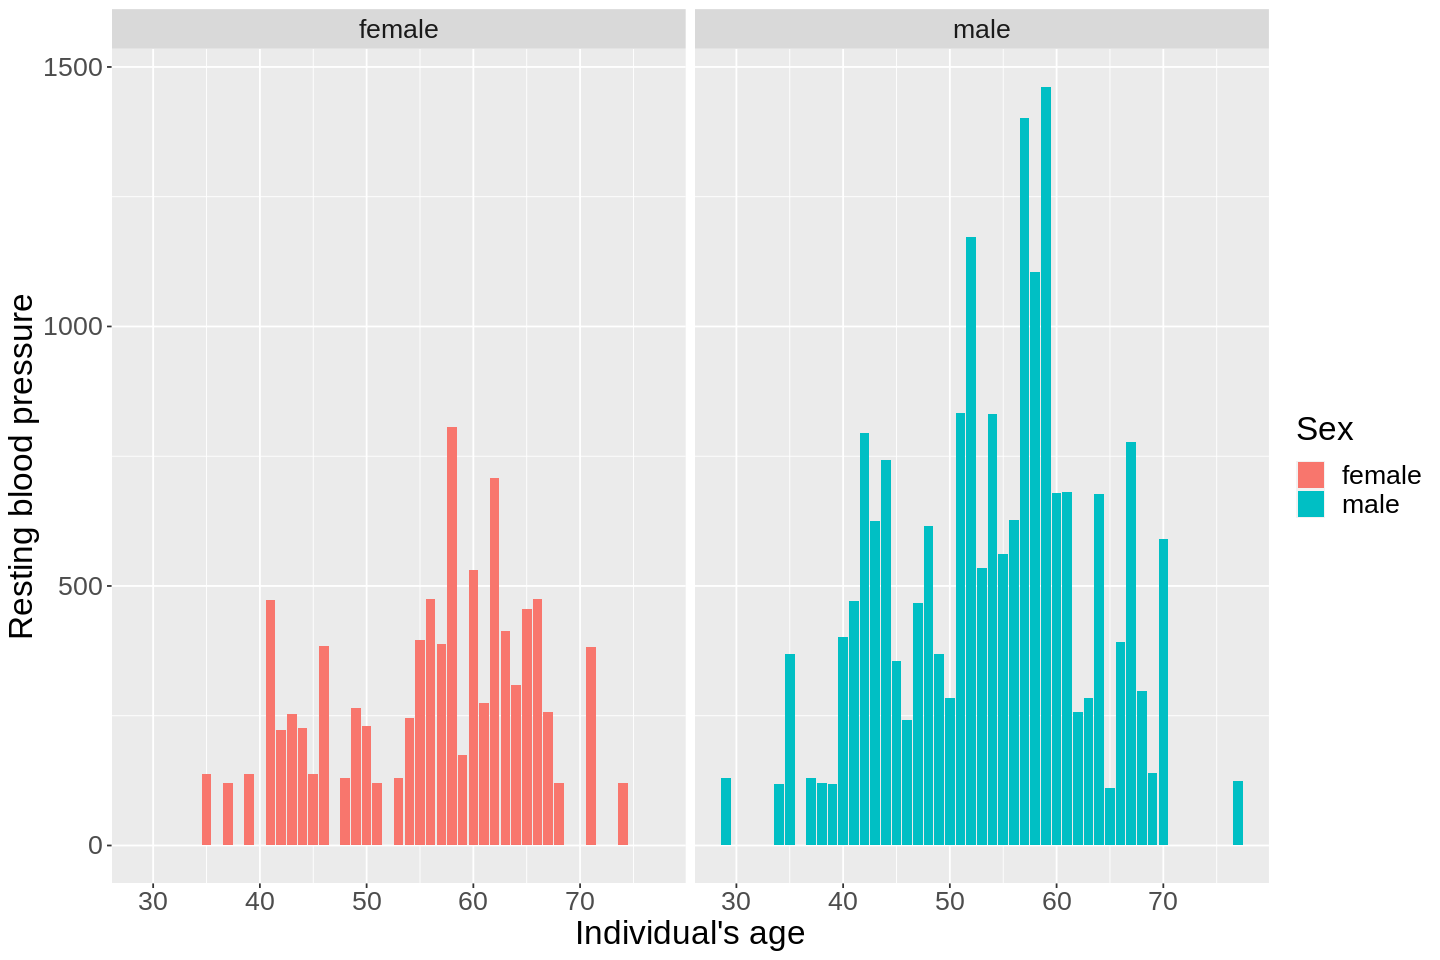

In [32]:
chol_plot <- heart_train %>%
    ggplot(aes(x = age, y = chol, fill = sex)) +
    geom_bar(stat = "identity") +
    facet_grid(. ~ sex) +
    labs(x = "Individual's age", y = "Cholesterol in blood (mg/dL)",
        fill = "Sex") +
    theme(text = element_text(size = 20))
chol_plot

restbps_plot <- heart_train %>%
    ggplot(aes(x = age, y = trestbps, fill = sex)) +
    geom_bar(stat = "identity") +
    facet_grid(. ~ sex) +
    labs(x = "Individual's age", y = "Resting blood pressure",
        fill = "Sex") +
    theme(text = element_text(size = 20))
restbps_plot

***Methods***

We will focus on age and the symptoms associated with heart failure. Simultaneously, in order to avoid differences in data due to gender, we'll split the sex variable into two separate charts (male/female). Before processing the data, we'll divide the age into three stages (e.g., adolescence, middle age, old age) to identify the age groups most susceptible to heart failure. Each stage is then discussed separately for each gender, comparing the frequency of each symptom and identifying the most obvious signs for each age group, which are presented in a chart.

***Expected Outcomes and Significance***

In order to help people become more aware of prevention with early detection and treatment, we aim to analyze the data to find signs associated with heart failure in different age groups. We expect to find specific signs that appear in specific age groups and/or sexes, so that we can etter target different populations with appropriate diagnoses and speculations. In the long run, this will be very effective in helping people to be aware of the possibility of heart failure when in poor health, to seek medical attention earlier, and to take better care of their bodies. At the same time, it will also help doctors to prescribe better-suited medication according to the patient's age and sex, and help patients recover sooner.